In [2]:
#函數有更新的時候會自動重新載入函數的指令
%load_ext autoreload
%autoreload 2
#-------------------------------------
import os
from dotenv import load_dotenv
import pandas as pd
import random
from API.FileReader import readPkl, readCsv, readGeneratedRegex
from API.FileProcessor import merge_dataframes_to_dict, prompt_generator, get_grouped_sid_to_regex_dict
from API.regexEvaluation import positive_evaluation, negative_evaluation
from API.Drawer import draw_outcome_histogram, draw_outcome_bar
from API.Drawer import draw_positive_contribution_of_generated_regex, draw_negative_contribution_of_generated_regex


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Post-Processor

In [41]:
# First, let's read the contents of the CSV file to understand its structure and data.
import pandas as pd
import ast

# Load the CSV file
file_path = r"C:\NCU\Intern\AutomaticNetwork IntrusionRuleGeneration\experiment\6 out of 9_2\generated regex.csv"
data = pd.read_csv(file_path)

def clean_and_convert(row):
    """Attempt to clean and convert dictionary strings to actual Python dictionaries."""
    try:
        # Clean up the string by removing unnecessary citations, replacing incorrect escape characters,
        # and removing extra newlines/spaces
        cleaned_string = (row.replace('\\t', '')
                          .replace("``` &#8203;:citation[oaicite:0]{index=0}&#8203;", "").strip())
        # Convert the cleaned string to a dictionary using ast.literal_eval for safe evaluation
        dictionary = ast.literal_eval(cleaned_string)
        return dictionary
    except Exception as e:
        # Return the error for debugging if conversion fails
        return {"error": str(e)}

def process_data(data):
    """Apply the cleaning and converting function to the 'dictionary' column."""
    data['cleaned_dictionary'] = data['dictionary'].apply(clean_and_convert)
    return data

def display_results(data):
    """Display the results of the conversions, separating successful from failed conversions."""
    successful_conversions = data[data['cleaned_dictionary'].apply(lambda x: isinstance(x, dict) and 'error' not in x)]
    conversion_errors = data[data['cleaned_dictionary'].apply(lambda x: isinstance(x, dict) and 'error' in x)]
    return successful_conversions, conversion_errors
def store_prossed_regex_csv(success, errors, success_csv_path, errors_csv_path):
    # Saving the 'success' DataFrame to a CSV file
    success.to_csv('success_csv_path.csv', index=False)
    # Saving the 'errors' DataFrame to a CSV file
    errors.to_csv('errors_csv_path.csv', index=False)
    
def store_prossed_regex_txt(success, errors, success_txt_path, errors_txt_path):
    with open('success_txt_path.txt', 'w') as file:
        file.write("Successful Conversions:\n")
        for index, row in success.iterrows():
            file.write(f"Row {index}:\n")
            file.write(f"Original: {row['dictionary']}\n")
            file.write(f"Converted: {row['cleaned_dictionary']}\n\n")

    with open('errors_txt_path.txt', 'w') as file:
        file.write("Conversion Errors:\n")
        for index, row in errors.iterrows():
            file.write(f"Row {index}:\n")
            file.write(f"Original: {row['dictionary']}\n")
            file.write(f"Error: {row['cleaned_dictionary']['error']}\n\n")
def merge_cleaned_dictionaries(dataframe):
    """
    Merges all cleaned dictionaries from the given DataFrame into a single dictionary.
    Converts all keys to strings to ensure consistency and removes duplicate values under the same key.

    Parameters:
    - dataframe (pd.DataFrame): DataFrame containing the 'cleaned_dictionary' column.

    Returns:
    - dict: A merged dictionary with all keys as strings and unique values.
    """
    merged_cleaned_dictionary = {}
    for index, row in dataframe.iterrows():
        for key, value in row['cleaned_dictionary'].items():
            # Convert key to string to ensure consistency
            key = str(key)
            if key in merged_cleaned_dictionary:
                # Append new values to the existing list if the key is already in the dictionary
                merged_cleaned_dictionary[key].extend(value)
            else:
                # Otherwise, start a new list for this key
                merged_cleaned_dictionary[key] = value

    # Removing duplicates in the lists for each key
    for key, values in merged_cleaned_dictionary.items():
        # Convert list to a set and back to a list to remove duplicates
        merged_cleaned_dictionary[key] = list(set(values))

    return merged_cleaned_dictionary

# Example usage:
processed_data = process_data(data)
success, errors = display_results(processed_data)
print(processed_data)


# print("Successful Conversions:")
#rint(success[['dictionary', 'cleaned_dictionary']])
# print("\nConversion Errors:")
# print(errors[['dictionary', 'cleaned_dictionary']])
with open('success_txt_path.txt', 'w') as file:
        file.write("Successful Conversions:\n")
        for index, row in success.iterrows():
            file.write(f"Row {index}:\n")
            file.write(f"Original: {row['dictionary']}\n")
            file.write(f"Converted: {row['cleaned_dictionary']}\n\n")

merged_cleaned_regex_dictionary = merge_cleaned_dictionaries(success)
with open('merged_cleaned_dictionary.txt', 'w') as file:
    for key, values in merged_cleaned_regex_dictionary.items():
        file.write(f"{key}:\n")
        for value in values:
            file.write(f"  {value}\n")
        file.write("\n")


                                           dictionary  \
0   {1161912: ["^DELE \d{1,3}\r\n$", "^DELE [1-9]\...   
1   {1161912: ["^DELE [0-9]+\r\n$", "^DELE [1-9][0...   
2   {\n    "1161912": ["^DELE \\d{1,3}\\r\\n$", "^...   
3   {\n  1176066: [\n    r"RETR \d+\r\n",\n    r"T...   
4   {\n    1176066: [\n        r'^RETR \d+\r\n$',\...   
5   {\n 1176066: [\n   "^(RETR \\d{1,3}|TOP \\d{1,...   
6   {\n    1239754: [\n        r"GET http:\/\/clie...   
7   {\n  1239754: [\n    "GET http:\/\/clientapi\....   
8   {\n    1239754: [\n        r"^GET http:\/\/cli...   
9   {\n  1454621: [\n    r"^EHLO [\d\.]+\r\n$",\n ...   
10  {\n    1454621: [\n        r"^EHLO [\w.-]+\r\n...   
11  {\n  1454621: [\n    "^EHLO (?:[A-Za-z0-9-]+\\...   
12  {\n  "1491662": [\n    "POST /ipp HTTP/1.1\\r\...   
13  {\n  1491662: [\n    r'^POST /ipp HTTP/1\.1\r\...   
14  {\n  1491662: [\n    'POST /ipp HTTP/1\\.1\\r\...   
15  {\n    1494383: [\n        r"REGISTER sip:[0-9...   
16  {\n    "1494383": [\n      

In [ ]:
import regex
for key, regex_patterns in merged_cleaned_regex_dictionary.items():
    print(f"Key: {key}")
    print("Regex Patterns:")
    for pattern in regex_patterns:
        print(bool(regex.search(pattern, 'GET /index.html HTTP/1.1')))
    print("\n")  # Print a newline for better separation between entries


### 讀取資料集

In [3]:

pop_df = readPkl("dataset/pop_report_with_tknscore_new.pkl")
imap_df = readPkl("dataset/imap_report_with_tknscore_new.pkl")
smtp_df = readPkl("dataset/smtp_report_with_tknscore_new.pkl")
sip_df = readPkl("dataset/sip_report_with_tknscore_new.pkl")
label_df = readCsv("dataset/sid_table(packet).csv")

### 將所有資料集轉換為dictionary

In [4]:

dfs = [pop_df, imap_df, smtp_df, sip_df]
sid_to_unique_texts_dict = merge_dataframes_to_dict(dfs)


In [ ]:
import regex
regex_pattern = r"^GET http://clientapi\.ipip\.net/echo\.php\?info=\d{14} HTTP/1\.1\nHost: clientapi\.ipip\.net\nAccept: \*/\*\nPragma: no-cache\nUser-Agent: Mozilla/5\.0 \(Windows NT 10\.0; WOW64\)\n*$"
text = '''GET http://clientapi.ipip.net/echo.php?info=20200106214554 HTTP/1.1

Host: clientapi.ipip.net

Accept: */*

Pragma: no-cache

User-Agent: Mozilla/5.0 (Windows NT 10.0; WOW64)'''
print(bool(regex.search(regex_pattern, text , regex.DOTALL)))

In [ ]:
# GeneratedPatternList = [
# "^(?:[A-Za-z0-9+/]{4}){1,}(?:[A-Za-z0-9+/]{2}==|[A-Za-z0-9+/]{3}=)?(?:\r\n)?$",
# "^[A-Za-z0-9+/=\r\n]+$",
# "^DELE \d+\r\n$",
# "^[Ee][Hh][Ll][Oo] [^\s]+\r\n$",
# "^([A-Za-z0-9+/=\r\n]+)$"                                                                                                                                                                                                                                                                                                 
# ]


# NEGATIVE_SAMPLE_NUMBER = 1000
# SID = '3000026'
# with open('test.txt', 'w') as file:
#     positive_evaluation(GeneratedPatternList, SID, sid_to_unique_texts_dict,file)
#     negative_evaluation(GeneratedPatternList, SID, sid_to_unique_texts_dict, NEGATIVE_SAMPLE_NUMBER,file)
# #後處理 "前面加\
# #把首尾的/去掉

### 實驗參數初始化


In [6]:

NUMBER_OF_ONE_REGEX_GROUP = 9
EXPERIMENT_NAME = "6 out of 9_4"
PROCESS_TYPE = "without post-process" #with/without post-process
MODE = "fraction" #fraction/integer
TRESHOLD = 1
#escaped_string = original_string.replace('"', '\\"')
if not os.path.exists(f"experiment/{EXPERIMENT_NAME}"):
    os.makedirs(f"experiment/{EXPERIMENT_NAME}")
    
#讀取csv 每個row是一個regex begin
#generated_regex_list: list = readGeneratedRegex(f"experiment/{EXPERIMENT_NAME}/generated regex.csv")
#grouped_sid_to_regex_dict = get_grouped_sid_to_regex_dict(generated_regex_list, 9, sid_to_unique_texts_dict)
#讀取csv 每個row是一個regex end

#讀取csv 每個row是一個dict+後處理 begin
#generated_regex_list = cleanAllNewlineinList(generated_regex_list)
#sid_to_unique_texts_dict = cleanAllNewlineinDict(sid_to_unique_texts_dict)
#grouped_sid_to_regex_dict = merged_cleaned_regex_dictionary
#讀取csv 每個row是一個dict+後處理 end
positive_sid_to_success_rate_dict = {}
negative_sid_to_seccess_rate_dict = {}
positive_text_to_error_regex_dict = {}
negative_text_to_error_regex_dict = {}

In [13]:
import os

# Set the directory containing the text files
directory_path = r"C:\NCU\Intern\AutomaticNetwork IntrusionRuleGeneration\experiment\6 out of 9_4\generated regex"

# Dictionary to hold the file contents
file_contents = {}

# Read each file in the directory and store its contents in the dictionary
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    with open(file_path, 'r', encoding='utf-8') as file:
        file_contents[filename] = file.readlines()

# Remove the '.txt' extension from the keys in the dictionary
file_contents_no_ext = {filename[:-4]: contents for filename, contents in file_contents.items()}

# Print the dictionary
print(file_contents_no_ext)
grouped_sid_to_regex_dict = file_contents_no_ext


{'1161912': ['^DELE \\d+\\r\\n$\n', '^DELE [0-9]+\\r\\n$\n', '^DELE [1-9][0-9]*\\r\\n$\n', '^(DELE\\s\\d+\\r\\n)$\n', '^DELE\\s\\d{1,3}\\r\\n$\n', '^DELE\\s\\d{1,3}\\r\\n$\n', '^(DELE \\d{1,3}\\r\\n)$\n', '^(DELE [0-9]{1,3}\\r\\n)$\n', '^(DELE \\d+\\r\\n)$'], '1176066': ['^(RETR \\d+\\r\\n|TOP \\d+ 0\\r\\n)$\n', '^RETR \\d+\\r\\n$\n', '^TOP \\d+ 0\\r\\n$\n', '^RETR \\d+\\r\\n$\n', '^TOP \\d+ 0\\r\\n$\n', '^(RETR \\d+\\r\\n|TOP \\d+ 0\\r\\n)$\n', '^(RETR|TOP) \\d{1,3}(\\r\\n)$\n', '^(RETR) \\d{1,3}(\\r\\n)$\n', '^(TOP) \\d{1,3} 0(\\r\\n)$'], '1239754': ['^GET http:\\/\\/clientapi\\.ipip\\.net\\/echo\\.php\\?info=\\d{14} HTTP\\/1\\.1\\r\\nHost: clientapi\\.ipip\\.net\\r\\nAccept: \\*\\/\\*\\r\\nPragma: no-cache\\r\\nUser-Agent: Mozilla\\/5\\.0 \\(Windows NT 10\\.0; WOW64\\)\\r\\n\\r\\n$\n', '^GET http:\\/\\/clientapi\\.ipip\\.net\\/echo\\.php\\?info=\\d{14} HTTP\\/1\\.1\\r\\nHost: clientapi\\.ipip\\.net\\r\\nAccept: \\*\\/\\*\\r\\nPragma: no-cache\\r\\nUser-Agent: Mozilla\\/5\\.0 \\(Wind

In [9]:
grouped_sid_to_regex_dict = file_contents_no_ext

NameError: name 'file_contents_no_ext' is not defined

### 開檔案

In [39]:
directory = f'./experiment/{EXPERIMENT_NAME}/graph/{PROCESS_TYPE}'
if not os.path.exists(directory):
    os.makedirs(directory)

### prompt生成

In [ ]:


prompt_generator(sid_to_unique_texts_dict, EXPERIMENT_NAME, 3)

In [ ]:
# pattern2 = '^GET http://clientapi\.ipip\.net/echo\.php\?info=\d{14} HTTP/1\.1\r\nHost: clientapi\.ipip\.net\r\nAccept: \*/\*\r\nPragma: no-cache\r\nUser-Agent: Mozilla/5\.0 \(Windows NT 10\.0; WOW64\)\r\n\r\n$'
# test_string2 = '''GET http://clientapi.ipip.net/echo.php?info=20200109135019 HTTP/1.1
# Host: clientapi.ipip.net
# Accept: */*
# Pragma: no-cache
# User-Agent: Mozilla/5.0 (Windows NT 10.0; WOW64)
# '''
# pattern = '^GET http://clientapi\.ipip\.net/echo\.php\?info=\d{14} HTTP/1\.1\nHost: clientapi\.ipip\.net\nAccept: \*/\*\nPragma: no-cache\nUser-Agent: Mozilla/5\.0 \(Windows NT 10\.0; WOW64\)\n\n$'
# test_string = '''GET http://clientapi.ipip.net/echo.php?info=20200109135019 HTTP/1.1
# Host: clientapi.ipip.net
# Accept: */*
# Pragma: no-cache
# User-Agent: Mozilla/5.0 (Windows NT 10.0; WOW64)

# '''
# result = bool(regex.search(pattern, test_string, regex.DOTALL))
# print(result)

### 執行正樣本比對與負樣本拒絕測試
- 將結果儲存於./experiment/{EXPERIMENT_NAME}/data/{PROCESS_TYPE}/sid.txt 
- 計算positive_sid_to_success_rate_dict, positive_text_to_error_regex_dict，negative_sid_to_seccess_rate_dict，negative_text_to_error_regex_dict用於後續的作圖

In [14]:
directory = f'./experiment/{EXPERIMENT_NAME}/data/{PROCESS_TYPE}'
if not os.path.exists(directory):
    os.makedirs(directory)
for sid, regex_list in grouped_sid_to_regex_dict.items():   
    with open(f'{directory}/{sid}.txt', 'w') as file:
        positive_evaluation(regex_list, sid, sid_to_unique_texts_dict, file, positive_sid_to_success_rate_dict, positive_text_to_error_regex_dict, TRESHOLD,MODE)
        negative_evaluation(regex_list, sid, sid_to_unique_texts_dict, file, negative_sid_to_seccess_rate_dict, negative_text_to_error_regex_dict, TRESHOLD, MODE)
#後處理 "前面加\
#把首尾的/去掉

### 計算貢獻度


In [17]:
# 建立 sid_to_unique_texts_dict
#sid_to_unique_texts_dict = {sid: set(texts) for sid, texts in grouped_sid_to_regex_dict.items()}
# 新的結果字典
draw_positive_contribution_of_generated_regex(grouped_sid_to_regex_dict, sid_to_unique_texts_dict, positive_text_to_error_regex_dict, EXPERIMENT_NAME)
draw_negative_contribution_of_generated_regex(grouped_sid_to_regex_dict, sid_to_unique_texts_dict, negative_text_to_error_regex_dict, EXPERIMENT_NAME)

c:\NCU\Intern\AutomaticNetwork IntrusionRuleGeneration\API\Drawer.py:168: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


Saved: ./experiment\6 out of 9_3\graph/contribution/positive
Saved: ./experiment\6 out of 9_3\graph/contribution/negative


In [ ]:
# base_path = os.path.join('./experiment', 'test', 'graph/contribution/positive')
# os.makedirs(base_path, exist_ok=True)

c:\NCU\Intern\AutomaticNetwork IntrusionRuleGeneration\API\Drawer.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sids, y=success_rates, palette="viridis")


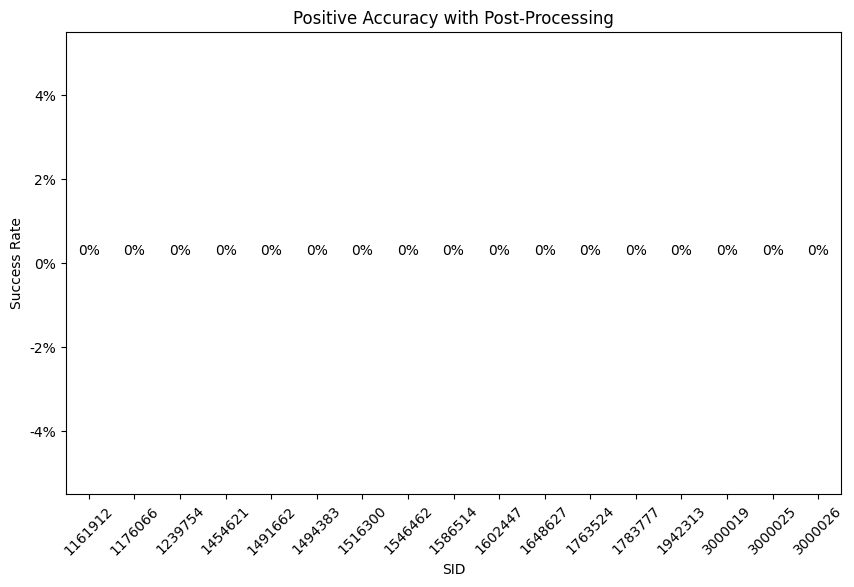

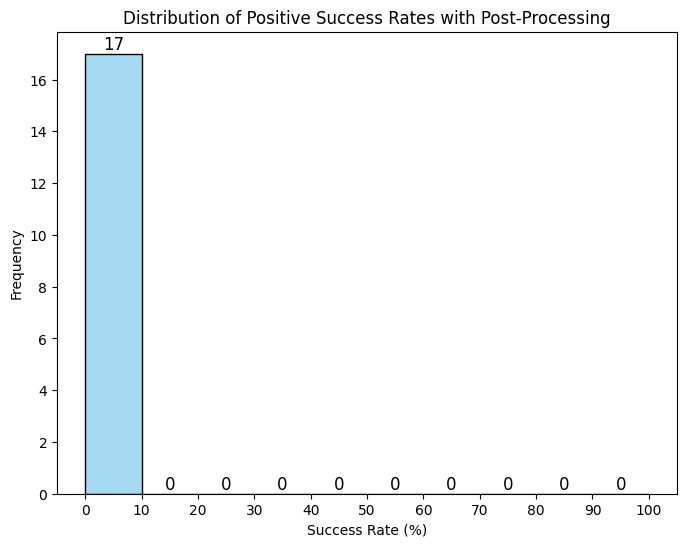

c:\NCU\Intern\AutomaticNetwork IntrusionRuleGeneration\API\Drawer.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sids, y=success_rates, palette="viridis")


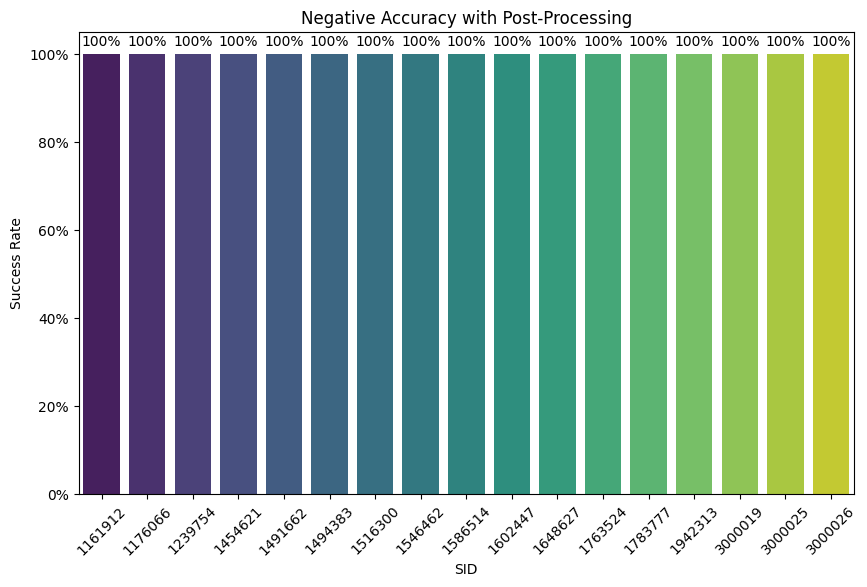

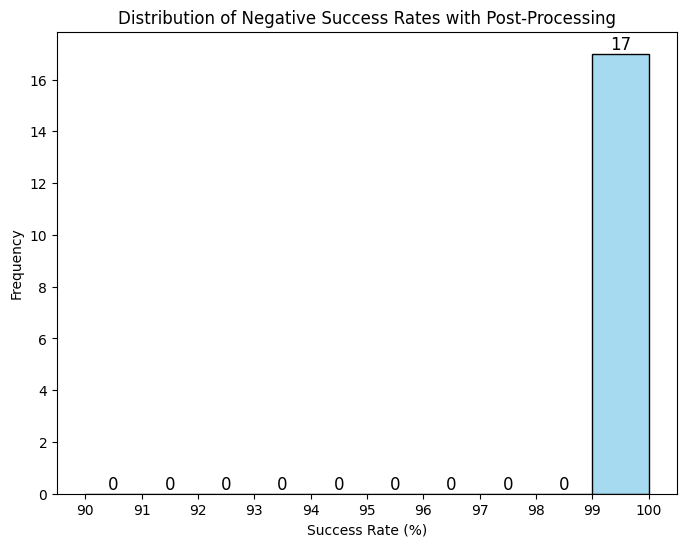

In [16]:
draw_outcome_bar(positive_sid_to_success_rate_dict,EXPERIMENT_NAME, "Positive Accuracy with Post-Processing")
draw_outcome_histogram(positive_sid_to_success_rate_dict, EXPERIMENT_NAME, "Distribution of Positive Success Rates with Post-Processing")
draw_outcome_bar(negative_sid_to_seccess_rate_dict,EXPERIMENT_NAME, "Negative Accuracy with Post-Processing")
draw_outcome_histogram(negative_sid_to_seccess_rate_dict, EXPERIMENT_NAME, "Distribution of Negative Success Rates with Post-Processing")

In [ ]:
import google.generativeai as genai
load_dotenv()

system_prompt = '''
Please find a regular expression to match all packet payloads.
You need to find the similarities in the sentences and generalize the parts where they differ. 
The regular expression is in PCRE format, please be aware to evaluate the validity of the expression you generated under PCRE regulations. 
There will be examples to help you find the patterns. 
[‘DELE 3\r\n’, ‘DELE 128\r\n’, ‘DELE 74\r\n’, ‘DELE 22\r\n’, ‘DELE 70\r\n’] 
These examples show the attacker is trying to delete someone’s email by POP protocol. 
The index of the desired mail is indicated under the DELE command. 
Thus the best regular expression that matches them will be ‘^(DELE)( )(.*)(\r\n)$’ 

With the given example payloads: 
[‘EHLO BtuCBHdSb51.com\r\n’, ‘EHLO 203.187.87.27\r\n’, ‘EHLO slae02Fo9Ep.com\r\n’, ‘EHLO 210.64.37.51\r\n’, ‘EHLO LLb0RwqdbkikFWo.com\r\n’] 
These examples show the attacker is trying to make sure the SMTP server is up and running. The command EHLO works in both lower case and uppercase, after that follows the SMTP server address. 
Thus the best regular expression to match them will be ‘^([E|e][H|h][L|l][O|o])(.*)(\r\n)$’ 

note: Your output must be a in jason format，no need to write Markdown
'''
user_prompt = '''
['DELE 107\r\n', 'DELE 124\r\n', 'DELE 113\r\n', 'DELE 7\r\n', 'DELE 105\r\n', 'DELE 71\r\n', 'DELE 122\r\n', 'DELE 25\r\n', 'DELE 61\r\n', 'DELE 100\r\n', 'DELE 65\r\n', 'DELE 52\r\n', 'DELE 69\r\n', 'DELE 43\r\n', 'DELE 21\r\n', 'DELE 67\r\n', 'DELE 90\r\n', 'DELE 14\r\n', 'DELE 109\r\n', 'DELE 77\r\n', 'DELE 73\r\n', 'DELE 104\r\n', 'DELE 45\r\n', 'DELE 10\r\n', 'DELE 89\r\n', 'DELE 3\r\n', 'DELE 120\r\n', 'DELE 96\r\n', 'DELE 48\r\n', 'DELE 95\r\n', 'DELE 110\r\n', 'DELE 12\r\n', 'DELE 27\r\n', 'DELE 56\r\n', 'DELE 34\r\n', 'DELE 55\r\n', 'DELE 132\r\n', 'DELE 38\r\n', 'DELE 26\r\n', 'DELE 86\r\n', 'DELE 115\r\n', 'DELE 103\r\n', 'DELE 17\r\n', 'DELE 101\r\n', 'DELE 8\r\n', 'DELE 11\r\n', 'DELE 33\r\n', 'DELE 53\r\n', 'DELE 88\r\n', 'DELE 76\r\n']
Please give 3 possible and different regular expressions to match all of the elements. 
You can give only 1 expression if the 3 expressions you find are too similar. 
Let’s work this out in a step-by-step way to make sure we have the right answer. 
To make the expression not too general, make sure the expressions don’t match these negative examples: [‘CAPA\r\n’, ‘CAPA\r\n’, ‘\x15\x03\x01’, ‘GET / HTTP/1.0\r\n\r\n’, ‘r\n\r\n’] 
You only need to give me the three regular expressions in code format.
'''
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')

genai.configure(api_key=GEMINI_API_KEY)

model=genai.GenerativeModel(
  model_name="gemini-1.5-flash",
  system_instruction=system_prompt,
)

response = model.generate_content(user_prompt)
print(response.text)

In [ ]:
### Gmni
load_dotenv()
import google.generativeai as genai
system_prompt = "You are a professional Regular Expression maker."

GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
genai.configure(api_key=GEMINI_API_KEY)

model=genai.GenerativeModel(
  model_name="gemini-1.5-flash"
)

### OLD CODE

In [ ]:
#獲取各個SID所對應到的text
def map_sid_to_unique_texts(df):
    sid_to_texts = {}
    for _, row in df.iterrows():
        sid = row['sid']
        text = row['text']
        if pd.notnull(text):  # Ensure text is not NaN
            if sid in sid_to_texts:
                sid_to_texts[sid].add(text)
            else:
                sid_to_texts[sid] = {text}
    return sid_to_texts
sid_to_unique_texts = map_sid_to_unique_texts(pop_df)
#print(sid_to_unique_texts)

In [ ]:
#過濾掉text長度小於5的sid
def filter_sids_by_text_length(sit_to_text_dict):
    filtered_sids = set()
    for key, value in sit_to_text_dict.items():
        if len(value) > 5:  # Convert to string to avoid errors with non-string types
            filtered_sids.add(key)
    return filtered_sids

# Assuming pop_df is your DataFrame
filtered_sids = filter_sids_by_text_length(sid_to_unique_texts)
#print(filtered_sids)
#print(len(filtered_sids))

In [ ]:
def get_pcre_by_sid(sid):
    with open('sid_table(packet).csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['SID'] == str(sid):
                # Remove leading and trailing slashes from the pcre value
                print (row['pcre'])
                return row['pcre'].strip('/')
    return None

# Iterate Throush Positive payload text to see if the ans regex is correct    
def is_ans_correct(sid):
    correct = 0
    total = 0
    errorList = []
    ansPattern = get_pcre_by_sid(str(sid))
    print(f"ansPattern: {ansPattern}")
    sid_to_unique_texts = map_sid_to_unique_texts(pop_df)
    texts = sid_to_unique_texts[sid]
    for text in texts:
        total = total + 1
        correct = correct + bool(regex.search(ansPattern, text,regex.DOTALL))
        if not bool(regex.search(r'/^(GET|HEAD|POST|OPTIONS)( )(\/|\/version|\/api.*|\/jsproxy)( )(HTTP\/1\.(?:0|1))(\r\n)(.*)$/', text,regex.DOTALL)):
            errorList.append(text)

    print("answer test")
    print(f"correct: {correct}, total: {total}")
    print(len(errorList))
    for error in errorList:
        print(f"error: {error}")
    return correct, total
is_ans_correct('1783777')

### ChatGPT API


In [ ]:
load_dotenv()
CHAT_GPT_API_KEY = os.getenv('C_API_KEY')
client = OpenAI(
    api_key=CHAT_GPT_API_KEY
)

completion = client.chat.completions.create(
  model="gpt-3.5-turbo-1106",
  messages=[
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Hello!"}
  ]
)

print(completion.choices[0].message)


### Gemini API

In [ ]:
import google.generativeai as genai
load_dotenv()

system_prompt = '''
Please find a regular expression to match all packet payloads.
You need to find the similarities in the sentences and generalize the parts where they differ. 
The regular expression is in PCRE format, please be aware to evaluate the validity of the expression you generated under PCRE regulations. 
There will be examples to help you find the patterns. 
[‘DELE 3\r\n’, ‘DELE 128\r\n’, ‘DELE 74\r\n’, ‘DELE 22\r\n’, ‘DELE 70\r\n’] 
These examples show the attacker is trying to delete someone’s email by POP protocol. 
The index of the desired mail is indicated under the DELE command. 
Thus the best regular expression that matches them will be ‘^(DELE)( )(.*)(\r\n)$’ 

With the given example payloads: 
[‘EHLO BtuCBHdSb51.com\r\n’, ‘EHLO 203.187.87.27\r\n’, ‘EHLO slae02Fo9Ep.com\r\n’, ‘EHLO 210.64.37.51\r\n’, ‘EHLO LLb0RwqdbkikFWo.com\r\n’] 
These examples show the attacker is trying to make sure the SMTP server is up and running. The command EHLO works in both lower case and uppercase, after that follows the SMTP server address. 
Thus the best regular expression to match them will be ‘^([E|e][H|h][L|l][O|o])(.*)(\r\n)$’ 

note: Your output must be a in jason format，no need to write Markdown
'''
user_prompt = '''
['DELE 107\r\n', 'DELE 124\r\n', 'DELE 113\r\n', 'DELE 7\r\n', 'DELE 105\r\n', 'DELE 71\r\n', 'DELE 122\r\n', 'DELE 25\r\n', 'DELE 61\r\n', 'DELE 100\r\n', 'DELE 65\r\n', 'DELE 52\r\n', 'DELE 69\r\n', 'DELE 43\r\n', 'DELE 21\r\n', 'DELE 67\r\n', 'DELE 90\r\n', 'DELE 14\r\n', 'DELE 109\r\n', 'DELE 77\r\n', 'DELE 73\r\n', 'DELE 104\r\n', 'DELE 45\r\n', 'DELE 10\r\n', 'DELE 89\r\n', 'DELE 3\r\n', 'DELE 120\r\n', 'DELE 96\r\n', 'DELE 48\r\n', 'DELE 95\r\n', 'DELE 110\r\n', 'DELE 12\r\n', 'DELE 27\r\n', 'DELE 56\r\n', 'DELE 34\r\n', 'DELE 55\r\n', 'DELE 132\r\n', 'DELE 38\r\n', 'DELE 26\r\n', 'DELE 86\r\n', 'DELE 115\r\n', 'DELE 103\r\n', 'DELE 17\r\n', 'DELE 101\r\n', 'DELE 8\r\n', 'DELE 11\r\n', 'DELE 33\r\n', 'DELE 53\r\n', 'DELE 88\r\n', 'DELE 76\r\n']
Please give 3 possible and different regular expressions to match all of the elements. 
You can give only 1 expression if the 3 expressions you find are too similar. 
Let’s work this out in a step-by-step way to make sure we have the right answer. 
To make the expression not too general, make sure the expressions don’t match these negative examples: [‘CAPA\r\n’, ‘CAPA\r\n’, ‘\x15\x03\x01’, ‘GET / HTTP/1.0\r\n\r\n’, ‘r\n\r\n’] 
You only need to give me the three regular expressions in code format.
'''
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')

genai.configure(api_key=GEMINI_API_KEY)

model=genai.GenerativeModel(
  model_name="gemini-1.5-flash",
  system_instruction=system_prompt,
)

response = model.generate_content(user_prompt)
print(response.text)

In [ ]:
def clean_json_string(s):
    # 使用正则表达式移除字符串前后的 '''json 和 '''
    cleaned_string = regex.sub(r"^'''json|'''$", '', s, flags=regex.MULTILINE).strip()
    return cleaned_string
output_string = clean_json_string(input_string)
output_string


### Evaluation Generated Regex
Randonly take 20 positive and 20 negateve data as input to generated regex and answer regex, comparing there result.

In [ ]:
#隨機選擇除了給定的SID以外的100個text
def select_random_texts(sid_to_unique_texts, given_sid, num_texts=100):
    # Filter out the given SID
    filtered_texts = [texts for sid, texts in sid_to_unique_texts.items() if sid != given_sid]
    
    # Flatten the list of lists to a single list of texts
    all_texts = [text for sublist in filtered_texts for text in sublist]
    
    # Randomly select 100 texts, or all texts if there are fewer than 100
    selected_texts = random.sample(all_texts, min(len(all_texts), num_texts))
    
    return selected_texts

def get_pcre_by_sid(sid):
    with open('sid_table(packet).csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['SID'] == str(sid):
                # Remove leading and trailing slashes from the pcre value
                return row['pcre']
    return None

def match_patterns(targetText, GeneratedPatternList,isPositive=True):
    non_matching_patterns = []  # Step 1: Initialize list for non-matching patterns
    # Check each pattern and add non-matching ones to the list
    for i, pattern in enumerate(GeneratedPatternList):
        if not regex.search(pattern, targetText, regex.DOTALL):
            non_matching_patterns.append(f"Pattern {i+1}: {pattern}")
    ourResult = True if (9-len(non_matching_patterns)) >= 7 else False
    with open('evaluation_result.txt', 'w') as file:
        for pattern in non_matching_patterns:
            file.write(pattern)
    #ansMatch = bool(regex.search(ansPattern, targetText))
    return ourResult == isPositive

def positive_answer_evaluation(threeAnsPattern,sid):
    correct = 0
    total = 0
    errorList = []
    ansPattern = get_pcre_by_sid(str(sid))
    print(f"ansPattern: {ansPattern}")
    sid_to_unique_texts = map_sid_to_unique_texts(pop_df)
    texts = sid_to_unique_texts[sid]
    for text in texts:
        total = total + 1
        correct = correct + bool(regex.search(ansPattern, text, regex.DOTALL))
        if not match_patterns(text, threeAnsPattern, True):
            errorList.append(text)

    print("positive test")
    print(f"correct: {correct}, total: {total}")
    print(f"errorList: {errorList}")
    return correct, total
def negative_answer_evaluation(GeneratedPatternList,sid):
    correct = 0
    total = 0
    errorList = []
    ansPattern = get_pcre_by_sid(str(sid))
    texts = select_random_texts(sid_to_unique_texts, sid)
    for text in texts:
        total = total + 1
        if(not regex.search(ansPattern, text, regex.DOTALL)):
            correct = correct + 1
        if  not match_patterns(text, GeneratedPatternList, False):
            errorList.append(text)
    print("negative test")
    print(f"correct: {correct}, total: {total}")
    for error_text in errorList:
        print(error_text)
    print(f"errorList: {errorList}")
    
def positive_evaluation(threeAnsPattern,sid,file):
    correct = 0
    total = 0
    errorList = []
    ansPattern = get_pcre_by_sid(str(sid))
    print(f"ansPattern: {ansPattern}")
    sid_to_unique_texts = map_sid_to_unique_texts(pop_df)
    texts = sid_to_unique_texts[sid]
    for text in texts:
        total = total + 1
        correct = correct + match_patterns(text, threeAnsPattern, True)
        if not match_patterns(text, threeAnsPattern, True):
            errorList.append(text)

    print("positive test")
    print(f"correct: {correct}, total: {total}")
    file.write('print("positive")\n')
    for error in errorList:
        file.write('print(f"errorList: {errorList}")\n')
    return correct, total

def negative_evaluation(GeneratedPatternList,sid,file):
    correct = 0
    total = 0
    errorList = []
    ansPattern = get_pcre_by_sid(str(sid))
    texts = select_random_texts(sid_to_unique_texts, sid)
    for text in texts:
        total = total + 1
        correct = correct + match_patterns(text, GeneratedPatternList, False)
        if  not match_patterns(text, GeneratedPatternList, False):
            errorList.append(text)
    file.write('print("negative")\n')
    for error in errorList:
        file.write('print(f"errorList: {errorList}")\n')
    print(f"correct: {correct}, total: {total}")
    for error_text in errorList:
        
    
regex1 = r"/^([E|e][H|h][L|l][O|o])( [a-zA-Z0-9.-]+)?(\r\n)$/"
regex2 = r"/^EHLO( [a-zA-Z0-9.-]+)?(\r\n)$/"
regex3 = r"/^([Ee][Hh][Ll][Oo])( [a-zA-Z0-9.-]+)?(\r\n)$/"
regex4 = r"^([E|e][H|h][L|l][O|o] [a-zA-Z0-9.-]+(\.[a-zA-Z]{2,})?\r\n)$"
regex5 = r"^([E|e][H|h][L|l][O|o] [a-zA-Z0-9.-]+(\.[a-zA-Z0-9.-]+)+\r\n|[E|e][H|h][L|l][O|o]\r\n)$"
regex6 = r"^([E|e][H|h][L|l][O|o]( [a-zA-Z0-9.-]+(\.[a-zA-Z0-9.-]+)+)?\r\n)$"
regex7 = r"^(EHLO|ehlo)( [^\r\n]+)?(\r\n)$"
regex8 = r"^([E|e][H|h][L|l][O|o])( [a-zA-Z0-9.-]+)?(\r\n)$"
regex9 = r"^([Ee][Hh][Ll][Oo])( [a-zA-Z0-9.-]+)?(\r\n)$"
GeneratedPatternList = [
    regex1, regex2, regex3, regex4, regex5, regex6, regex7, regex8, regex9
]

sid = '1454621'
positive_evaluation(GeneratedPatternList, sid)
negative_evaluation(GeneratedPatternList, sid)

### Helper Function

In [ ]:
def list_csv_columns():
    with open('sid_table(packet).csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        # Print all column names
        print(reader.fieldnames)

In [ ]:
#print filtered_sids and corresponding text
for sid in filtered_sids:
    print(f"sid: {sid}, text: {sid_to_unique_texts[sid]}")

In [ ]:
protocols = [
    {'name': 'pop_df', 'data': pop_df},
    {'name': 'imap_df', 'data': imap_df},
    {'name': 'smtp_df', 'data': smtp_df},
    {'name': 'sip_df', 'data': sip_df}
]

with open('prompt.txt', 'w') as file:
    pass

with open('prompt.txt', 'a') as file:
    for protocol in protocols:
        protocol_name = protocol['name']
        protocol_data = protocol['data']
        
        sid_to_unique_texts = map_sid_to_unique_texts(protocol_data)
        filtered_sids = filter_sids_by_text_length(sid_to_unique_texts)
        
        # Sort the filtered_sids to ensure the output is ordered by SID
        sorted_filtered_sids = sorted(filtered_sids)
        
        file.write(f"Protocol: {protocol_name}\n")
        
        for sid in sorted_filtered_sids:
            texts = list(sid_to_unique_texts[sid])
            random.shuffle(texts)
            selected_texts = texts[:50]
            file.write(f"sid: {sid}, text: {selected_texts}\n")
            file.write("\n")
            file.write("Please find a regular expression to match all packet payloads.\n" + 
                       "You need to find the similarities in the sentences and generalize the parts where they differ. \n" + 
                        "The regular expression is in PCRE format, please be aware to evaluate the validity of the expression you generated under PCRE regulations. \n" + 
                        "There will be examples to help you find the patterns. \n"  +
                        "[‘DELE 3\\r\\n’, ‘DELE 128\\r\\n’, ‘DELE 74\\r\\n’, ‘DELE 22\\r\\n’, ‘DELE 70\\r\\n’] \n" +
                        "These examples show the attacker is trying to delete someone’s email by POP protocol. \n" +
                        "The index of the desired mail is indicated under the DELE command. \n" +
                        "Thus the best regular expression that matches them will be ‘^(DELE)( )(.*)(\\r\\n)$’ \n" + "\n" +
                        "With the given example payloads: \n" +
                        "[‘EHLO BtuCBHdSb51.com\\r\\n’, ‘EHLO 203.187.87.27\\r\\n’, ‘EHLO slae02Fo9Ep.com\\r\\n’, ‘EHLO 210.64.37.51\\r\\n’, ‘EHLO LLb0RwqdbkikFWo.com\\r\\n’] \n" + 
                        "These examples show the attacker is trying to make sure the SMTP server is up and running. " + 
                        "The command EHLO works in both lower case and uppercase, after that follows the SMTP server address. \n" +
                        "Thus the best regular expression to match them will be ‘^([E|e][H|h][L|l][O|o])(.*)(\\r\\n)$’ \n" + "\n" +
                        "Next, with the given payloads: \n")
            file.write(f"{selected_texts}\n")         
            file.write("Please give 3 possible and different regular expressions to match all of the elements. \n" +
                        "You can give only 1 expression if the 3 expressions you find are too similar. \n" + 
                        "Let’s work this out in a step-by-step way to make sure we have the right answer. \n" + 
                        "To make the expression not too general, make sure the expressions don’t match these negative examples: [‘CAPA\\r\\n’, ‘CAPA\\r\\n’, ‘\\x15\\x03\\x01’, ‘GET / HTTP/1.0\\r\\n\\r\\n’, ‘r\\n\\r\\n’] \n" +
                        "You only need to give me the three regular expressions in code format.\n")
            file.write("\n")
        file.write("\n")

In [ ]:
with open('all_texts.txt', 'a') as file:
    for protocol in protocols:
        protocol_name = protocol['name']
        protocol_data = protocol['data']
        
        sid_to_unique_texts = map_sid_to_unique_texts(protocol_data)
        filtered_sids = filter_sids_by_text_length(sid_to_unique_texts)
        
        file.write(f"Protocol: {protocol_name}\n")
        
        for sid in filtered_sids:
            file.write(f"sid: {sid}, text: {sid_to_unique_texts[sid]}\n")
                            
        file.write("\n")

In [ ]:
#獲取特定資料集的所有SID
def get_unique_sids_list(df):
    unique_sids = df[df['text'].notnull()]['sid'].unique()
    return unique_sids
sidList = get_unique_sids_list(pop_df)
print(sidList)
#print(len(sidList))